# Energy density & prices

In [93]:
import pandas as pd
import sqlite3

import sqlalchemy as sa
import matplotlib.pyplot as plt
from datetime import datetime, date

import re
import numpy as np
%run '../serv_energy.py'
eng_co=sa.create_engine('sqlite+pysqlite:///fuels.sqlite3') #, echo=True)

## Read data from local DB
Local DB filled from Internet sources.

In [282]:
#oils
pdfOILS=FuelsDataFrame(pd.read_sql('SELECT * FROM ALL_OILS', con=eng_co, index_col='Date'))
print(pdfOILS.tail(10))

#coals
pdfCOAL=pd.read_sql('SELECT * FROM COALS', con=eng_co, index_col='Date').astype(float)
pdfNYM_COAL=pd.read_sql('SELECT * FROM NYMEX_COALS', con=eng_co, index_col='Date').astype(float)
pdfNYM_COAL['E_R']=pdfNYM_COAL[['EASTERN_RAIL', 'NYMEX_APPALACHIAN']].mean(axis=1)
#print(pdfNYM_COAL.tail(10))

pdfCOAL=pdfCOAL.merge(pdfNYM_COAL[['E_R']], left_index=True, right_index=True)

print(pdfCOAL.tail(10))

#uranium
pdfURAN=FuelsDataFrame(pd.read_sql('SELECT * FROM URANIUM', con=eng_co, index_col='Date'))
print(pdfURAN.tail(10))

#gas - natural and LNG
pdfGAS=pd.read_sql('SELECT * FROM ALL_GAS', con=eng_co, index_col='Date').astype(float)
print(pdfGAS.tail(10))

          CRUDE_BRENT  CRUDE_WTI  CRUDE_DUBAI  CRUDE_URALS
Date                                                      
Dec-2017        64.21      57.94        61.41        63.77
Jan-2018        68.99      63.67        66.02        68.60
Feb-2018        65.42      62.17        62.79        63.14
Mar-2018        66.45      62.76        63.29        63.58
Apr-2018        71.63      66.32        68.43        69.10
May-2018        76.65      69.98        73.66        75.14
Jun-2018        75.19      67.52        73.22        73.06
Jul-2018        74.44      70.84        72.72        72.84
Aug-2018        73.13      67.99        72.13        71.52
Sep-2018        78.86      70.21        77.02        78.13
          COAL_AUS  COAL_COL  COAL_SAFRICA        E_R
Date                                                 
Dec-2017    100.81       NaN         95.48  71.562030
Jan-2018    106.45       NaN         97.48  71.229762
Feb-2018    105.24       NaN         92.68  71.027119
Mar-2018     96.66    

## Read Energy Density and Density from local DB

In [248]:
pdfCOEFF=pd.read_sql('SELECT * FROM f_digest', con=eng_co)
print(pdfCOEFF)

#print(pdfCOEFF.loc[pdfCOEFF.name_e.str.lower()=='crude oil', ('ED_min', 'ED_max')])

             name_r                         name_e       SE_min       SE_max  \
0     Природный газ                    Natural gas        53.60        53.60   
1            Пропан                    LPG propane        49.60        49.60   
2             Бутан                     LPG butane        49.10        49.10   
3            Бензин              Gasoline (petrol)        46.40        46.40   
4             Нефть                      Crude oil        46.30        46.30   
5            Дизель                    Diesel fuel        45.60        45.60   
6        Газохол 10                    Gasohol E10        43.54        43.54   
7           Керосин   Jet A aviation fuel/kerosene        42.80        42.80   
8         Биодизель  Biodiesel oil (vegetable oil)        42.20        42.20   
9        Газохол 85                   Gasohol E85         33.10        33.10   
10  Уголь, антрацит               Coal, anthracite        26.00        33.00   
11   Уголь битумный               Coal, 

## Calculations
1. Conversion to liters for various fuels kind
2. Calculate price for MJ in various fuels kind - price for unit divided by Energy Density (exmpl: $/bbl divide by MJ/L -> $/L divide by MJ/L, volume units are reduced -> $/MJ) 

In [288]:
#cinversion functions

def barrel2litr(val):
    return float(val)/158.987
    
def tonne2litr(val, density):
    #print(val, density, direction, (float(val)/density)*1000, )
#    if val==np.nan: return 0

# density here - bulk density, its may be wrong
    return (float(val)/density)/1000
        
def mmbtu2litre(val):
    #28.52
    return (float(val)/28.52)/1000
        
def lb2litr(val, direction=1):
    # U3O8 in lb -> kilo -> ~0.8 uranium in yeallowcake
    # yellowcake density is 9.6 g/cm^3 -> 9600 kg/m^3
    return (float(val)*0.8)/0.453592


#print(pdfURAN.applymap(lambda x:lb2litr(x)/3456000*9.6))
#print(pdfURAN.applymap(lambda x:lb2litr(x)/443000*9.6))

ur_ed=FuelsDataFrame(pdfURAN)

ur_ed['max']=ur_ed.apply(lambda x:lb2litr(x['U3O8'])/443000*9.6, axis=1)
ur_ed['min']=ur_ed.apply(lambda x:lb2litr(x['U3O8'])/3456000*9.6, axis=1)
#ur_ed['max']=pdfURAN['U3O8'].apply(lambda x:lb2litr(x)/3456000*9.6, axis=1)
print(ur_ed.tail(10))

           U3O8       min       max
Date                               
Dec-2017  22.32  0.000109  0.000853
Jan-2018  21.88  0.000107  0.000836
Feb-2018  21.38  0.000105  0.000817
Mar-2018  21.05  0.000103  0.000805
Apr-2018  21.00  0.000103  0.000803
May-2018  22.73  0.000111  0.000869
Jun-2018  22.65  0.000111  0.000866
Jul-2018  25.78  0.000126  0.000985
Aug-2018  26.30  0.000129  0.001005
Sep-2018  27.50  0.000135  0.001051


In [250]:
#natural gas

ng_enr_dens=pdfCOEFF.loc[pdfCOEFF.name_e.str.contains(r'(?i)gas\b'), ('name_e', 'ED_min', 'ED_max', 'D_min', 'D_Max')]
ng_ed=(float(ng_enr_dens.iloc[0]['ED_max'])+float(ng_enr_dens.iloc[0]['ED_min']))/2
pdfGAS_ED=FuelsDataFrame(pdfGAS.applymap(lambda x:mmbtu2litre(x)/ng_ed))
print(pdfGAS_ED.tail(10))

             NG_HH  NG_EUROPE  LNG_BRAS    LNG_CH   LNG_JAP  LNG_SPAIN  \
Date                                                                     
Dec-2017  0.002716   0.006319  0.009055  0.009536  0.009633   0.008958   
Jan-2018  0.003728   0.007282  0.009922  0.010500  0.010500   0.007706   
Feb-2018  0.002572   0.006618  0.009055  0.009055  0.009151   0.006936   
Mar-2018  0.002591   0.006772  0.007417  0.007514  0.007610   0.006936   
Apr-2018  0.002697   0.007523  0.006839  0.006839  0.006936   0.006647   
May-2018  0.002697   0.006926  0.007610  0.008091  0.008091   0.007610   
Jun-2018  0.002861        NaN  0.009440  0.009825  0.009922   0.007803   
Jul-2018  0.002726        NaN  0.009440  0.009825  0.009825   0.007899   
Aug-2018  0.002851        NaN  0.009633  0.010018  0.010018   0.008284   
Sep-2018  0.002890        NaN  0.010981  0.011174  0.011174   0.009536   

            LNG_UK  
Date                
Dec-2017  0.007706  
Jan-2018  0.007032  
Feb-2018  0.006743  
Mar-20

In [251]:
#oil

oil_enr_dens=pdfCOEFF.loc[pdfCOEFF.name_e.str.lower()=='crude oil', ('ED_min', 'ED_max')].applymap(float).mean(axis=1)
k_oils=oil_enr_dens.values[0]
pdfOIL_ED=FuelsDataFrame(pdfOILS.applymap(lambda x:barrel2litr(x)/k_oils))
print(pdfOIL_ED.tail(10))

          CRUDE_BRENT  CRUDE_WTI  CRUDE_DUBAI  CRUDE_URALS
Date                                                      
Dec-2017     0.010915   0.009850     0.010439     0.010841
Jan-2018     0.011728   0.010824     0.011223     0.011662
Feb-2018     0.011121   0.010569     0.010674     0.010733
Mar-2018     0.011296   0.010669     0.010759     0.010808
Apr-2018     0.012177   0.011274     0.011633     0.011747
May-2018     0.013030   0.011896     0.012522     0.012773
Jun-2018     0.012782   0.011478     0.012447     0.012420
Jul-2018     0.012654   0.012042     0.012362     0.012382
Aug-2018     0.012432   0.011558     0.012262     0.012158
Sep-2018     0.013406   0.011935     0.013093     0.013282


In [252]:
#coal

coals_enr_dens=pdfCOEFF.loc[pdfCOEFF.name_e.str.contains(r'(?i)coal\b,\s(?!lignite)'), ('name_e', 'ED_min', 'ED_max', 'D_min', 'D_max')].set_index('name_e')
coals_enr_dens=coals_enr_dens[['ED_min', 'ED_max', 'D_min']].applymap(float).mean()
coal_dens=coals_enr_dens['D_min']
coals_ed=(coals_enr_dens['ED_max']+coals_enr_dens['ED_min'])/2
#print(coal_dens, coals_ed)
#print(pdfCOAL.tail(10))

pdfCOAL_ED1=FuelsDataFrame(pdfCOAL.applymap(lambda x:tonne2litr(x, density=coal_dens/1000)/coals_enr_dens['ED_min']))
pdfCOAL_ED2=FuelsDataFrame(pdfCOAL.applymap(lambda x:tonne2litr(x, density=coal_dens/1000)/coals_enr_dens['ED_max']))
#print(pdfCOAL_ED1.tail(10))
#print(pdfCOAL_ED2.tail(10))

pdfCOAL_ED=pd.merge(pdfCOAL_ED1, pdfCOAL_ED2, left_index=True, right_index=True, suffixes=('X_', 'Y_'))
pdfCOAL_ED['max']=pdfCOAL_ED.max(axis=1, skipna=True)
pdfCOAL_ED['min']=pdfCOAL_ED.min(axis=1, skipna=True)

pdfCOAL_ED=pdfCOAL_ED[['min', 'max']]
print(pdfCOAL_ED.tail(10))

               min       max
Date                        
Dec-2017  0.001909  0.004123
Jan-2018  0.001900  0.004354
Feb-2018  0.001895  0.004304
Mar-2018  0.001860  0.003953
Apr-2018  0.001750  0.003811
May-2018  0.001692  0.004344
Jun-2018  0.001791  0.004693
Jul-2018  0.001877  0.004890
Aug-2018  0.001947  0.004799
Sep-2018  0.002083  0.004669


/home/egor/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:870: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_lowerdim(tup)


# Plotting

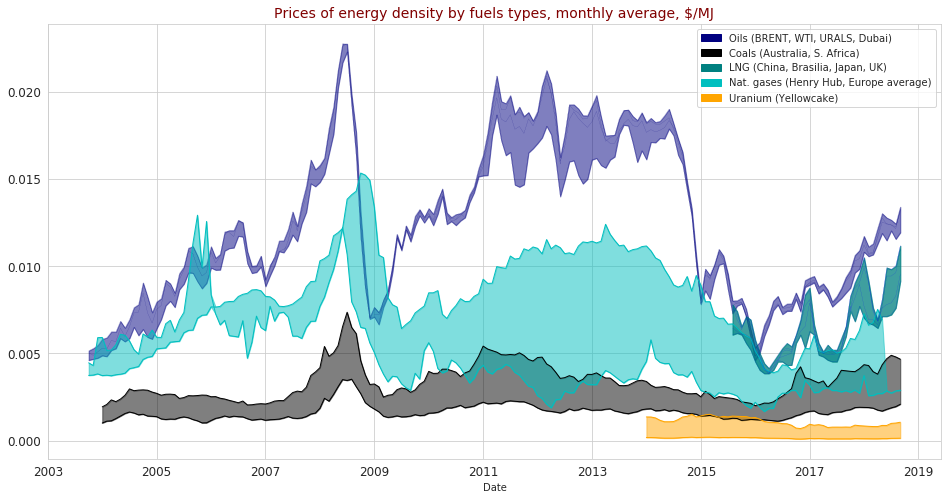

In [293]:
%matplotlib inline
import matplotlib.patches as mpatches

import seaborn as sns
sns.set_style('whitegrid')

iTailPoints=180 # months -> years ago

fig, ax=plt.subplots(figsize=(16,8))

oil_ped=pdfOIL_ED.tail(iTailPoints)

oil_ped.index_to_datetime()

oil_ped.plot.line(ax=ax, grid=True, legend=False, color='navy', lw=0.1, fontsize=12, rot=0)

coal_ped=pdfCOAL_ED.tail(iTailPoints)
coal_ped.index_to_datetime()
coal_ped.plot.line(ax=ax, grid=True, legend=False, color='black', lw=1)

gas_ped=pdfGAS_ED.tail(iTailPoints)[['NG_HH', 'NG_EUROPE']]
gas_ped.index_to_datetime()

gas_ped.plot.line(ax=ax, grid=True, legend=False, color='c', lw=1,)

lng_ped=pdfGAS_ED.tail(iTailPoints)[['LNG_BRAS', 'LNG_CH', 'LNG_JAP', 'LNG_SPAIN', 'LNG_UK']]
lng_ped.index_to_datetime()

lng_ped.plot.line(ax=ax, grid=True, legend=False, color='blue', lw=0.1)

uran_ped=ur_ed.tail(iTailPoints)[['min', 'max']]
uran_ped.index_to_datetime()
uran_ped.plot.line(ax=ax, grid=True, legend=False, color='orange', lw=1)
#print(oil_ped.min(axis=1, skipna=True))

ax.fill_between(oil_ped.index, oil_ped.min(axis=1, skipna=True), oil_ped.max(axis=1, skipna=True), alpha=0.5, color='navy')
ax.fill_between(coal_ped.index, coal_ped.min(axis=1, skipna=True), coal_ped.max(axis=1, skipna=True), alpha=0.5, color='black')
ax.fill_between(gas_ped.index, gas_ped.min(axis=1, skipna=True), gas_ped.max(axis=1, skipna=True), alpha=0.5, color='c')
ax.fill_between(lng_ped.index, lng_ped.min(axis=1, skipna=True), lng_ped.max(axis=1, skipna=True), alpha=0.5, color='teal')
ax.fill_between(lng_ped.index, lng_ped.min(axis=1, skipna=True), lng_ped.max(axis=1, skipna=True), alpha=0.5, color='teal')

ax.fill_between(uran_ped.index, uran_ped.min(axis=1, skipna=True), uran_ped.max(axis=1, skipna=True), alpha=0.5, color='orange')

ax.set_title('Prices of energy density by fuels types, monthly average, $/MJ', fontsize=14, color='maroon')

blue_pt=mpatches.Patch(color='navy', label='Oils (BRENT, WTI, URALS, Dubai)')
black_pt=mpatches.Patch(color='black', label='Coals (Australia, S. Africa)')
cyan_pt=mpatches.Patch(color='c', label='Nat. gases (Henry Hub, Europe average)')
lng_pt=mpatches.Patch(color='teal', label='LNG (China, Brasilia, Japan, UK)')
orange_pt=mpatches.Patch(color='orange', label='Uranium (Yellowcake)')
ax.legend(handles=[blue_pt, black_pt, lng_pt, cyan_pt, orange_pt])

plt.show();
